In [1]:
%load_ext autoreload
%autoreload 2

## Load data and import package

In [4]:
import numpy as np
import scanpy as sc
from scib_metrics.benchmark import Benchmarker
import time
from pathlib import Path
import torch
import Concord as ccd
%matplotlib inline

In [108]:
proj_name = "simulate_batch_pbmc3k"
data_dir = Path(f"../data/{proj_name}/")
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
seed = 0
ccd.ul.set_seed(seed)
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"

In [115]:
adata = sc.datasets.pbmc3k()
adata_processed = sc.datasets.pbmc3k_processed()
adata = adata[adata_processed.obs.index]
adata.obs = adata_processed.obs
adata.obsm = adata_processed.obsm
adata.layers['counts'] = adata.X.copy()

## Simulate batch

In [120]:
import numpy as np
import anndata as ad
import scipy.sparse as sp

def simulate_batch(
    adata: ad.AnnData,
    effect_type: str = 'mean_shift',
    effect_strength: float = 1.0,
    cell_proportion: float = 0.3,
    batch_name: str = 'batch_1',
    seed: int = 42
) -> ad.AnnData:
    """
    Simulate a single batch effect on a subset of cells from the input AnnData object.
    
    Parameters:
    -----------
    adata : anndata.AnnData
        The input AnnData object containing the original single-cell data.
    effect_type : str
        The type of batch effect to simulate. Options include:
        - 'mean_shift': Adds a shift to the mean expression.
        - 'variance_inflation': Inflates the variance of gene expression.
        - 'dropout_increase': Increases the dropout rate.
        - 'scaling_factor': Scales the gene expression levels.
    effect_strength : float
        The degree of the effect to introduce (magnitude of batch effect).
    cell_proportion : float
        The proportion of cells to include in this batch (0 < cell_proportion ≤ 1).
    batch_name : str
        The name of the batch to assign to the cells.
    seed : int
        Random seed for reproducibility.

    Returns:
    --------
    batch_adata : anndata.AnnData
        An AnnData object containing the subset of cells with the simulated batch effect,
        and a new column `batch` in `batch_adata.obs` indicating the batch name.
    """
    np.random.seed(seed)

    if not (0 < cell_proportion <= 1):
        raise ValueError("cell_proportion must be between 0 and 1.")

    # Determine the number of cells to sample
    n_cells = int(adata.n_obs * cell_proportion)
    
    # Randomly sample cells without replacement
    cell_indices = np.random.choice(adata.n_obs, size=n_cells, replace=False)
    
    # Create a subset AnnData object
    batch_adata = adata[cell_indices].copy()
    
    # Assign batch name
    batch_adata.obs['batch'] = batch_name

    # Apply the specified batch effect
    if effect_type == 'mean_shift':
        # Shift the mean expression
        shift_vector = np.random.normal(loc=effect_strength, scale=0.1, size=batch_adata.n_vars)
        if sp.issparse(batch_adata.X):
            # For sparse matrix, add shift_vector to each row
            batch_adata.X = batch_adata.X + shift_vector
        else:
            batch_adata.X += shift_vector
    elif effect_type == 'variance_inflation':
        # Inflate the variance
        scale_vector = 1 + np.random.normal(loc=0, scale=effect_strength, size=batch_adata.n_vars)
        if sp.issparse(batch_adata.X):
            # Create a sparse diagonal matrix from the scale_vector
            scaling_matrix = sp.diags(scale_vector)
            # Multiply batch_adata.X by the scaling matrix
            batch_adata.X = batch_adata.X @ scaling_matrix
        else:
            batch_adata.X *= scale_vector
    elif effect_type == 'dropout_increase':
        # Increase the dropout rate
        dropout_prob = effect_strength * np.random.rand(batch_adata.n_obs, batch_adata.n_vars)
        dropout_mask = np.random.rand(batch_adata.n_obs, batch_adata.n_vars) < dropout_prob
        if sp.issparse(batch_adata.X):
            batch_adata.X = batch_adata.X.toarray()
            batch_adata.X[dropout_mask] = 0
            batch_adata.X = sp.csr_matrix(batch_adata.X)
        else:
            batch_adata.X[dropout_mask] = 0
    elif effect_type == 'scaling_factor':
        # Apply a scaling factor
        scaling_vector = np.random.uniform(low=1-effect_strength, high=1+effect_strength, size=batch_adata.n_vars)
        if sp.issparse(batch_adata.X):
            scaling_matrix = sp.diags(scaling_vector)
            batch_adata.X = batch_adata.X @ scaling_matrix
        else:
            batch_adata.X *= scaling_vector
    else:
        raise ValueError(f"Unknown effect_type '{effect_type}'. Choose from 'mean_shift', 'variance_inflation', 'dropout_increase', or 'scaling_factor'.")

    return batch_adata


In [121]:
adata_b1 = simulate_batch(
    adata,
    effect_type='mean_shift',
    effect_strength=5.0,
    cell_proportion=0.3,
    batch_name='b_meanshift',
    seed=42
)

In [122]:
adata_b2 = simulate_batch(
    adata,
    effect_type='dropout_increase',
    effect_strength=1.0,
    cell_proportion=0.3,
    batch_name='b_dropout',
    seed=43
)

In [123]:
adata_b3 = simulate_batch(
    adata,
    effect_type='variance_inflation',
    effect_strength=0.5,
    cell_proportion=0.3,
    batch_name='batch_variance',
    seed=44
)

In [124]:
adata_b4 = simulate_batch(
    adata,
    effect_type='scaling_factor',
    effect_strength=0.2,
    cell_proportion=0.3,
    batch_name='batch_scaling',
    seed=45
)

In [125]:
adata_original = adata.copy()
adata_original.obs['batch'] = 'original'

# Sample cells for the original batch to match the desired proportion
cell_proportion_original = 0.4  # Adjust as needed
n_cells_original = int(adata.n_obs * cell_proportion_original)
cell_indices_original = np.random.choice(adata.n_obs, size=n_cells_original, replace=False)
adata_original = adata_original[cell_indices_original].copy()


In [140]:
adata = ad.concat([adata_original, adata_b1, adata_b2, adata_b4], join='outer', index_unique=None)
adata.X = np.round(adata.X).astype(int)
adata.layers['counts'] = adata.X.copy()


In [127]:
adata.write_h5ad(Path(data_dir) / f"adata_simulated_{file_suffix}.h5ad")

In [85]:
adata = sc.read_h5ad(Path(data_dir) / f'adata_simulated_simulate_batch_pbmc3k_Oct11-2102.h5ad')

In [135]:
adata_b4.X.A[100:120,100:120]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.88801502, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

## Uncorrected

In [141]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
adata = adata[:, adata.var.highly_variable]

In [142]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata, min_dist=0.1)

In [89]:
adata.obsm

AxisArrays with keys: X_draw_graph_fr, X_pca, X_tsne, X_umap

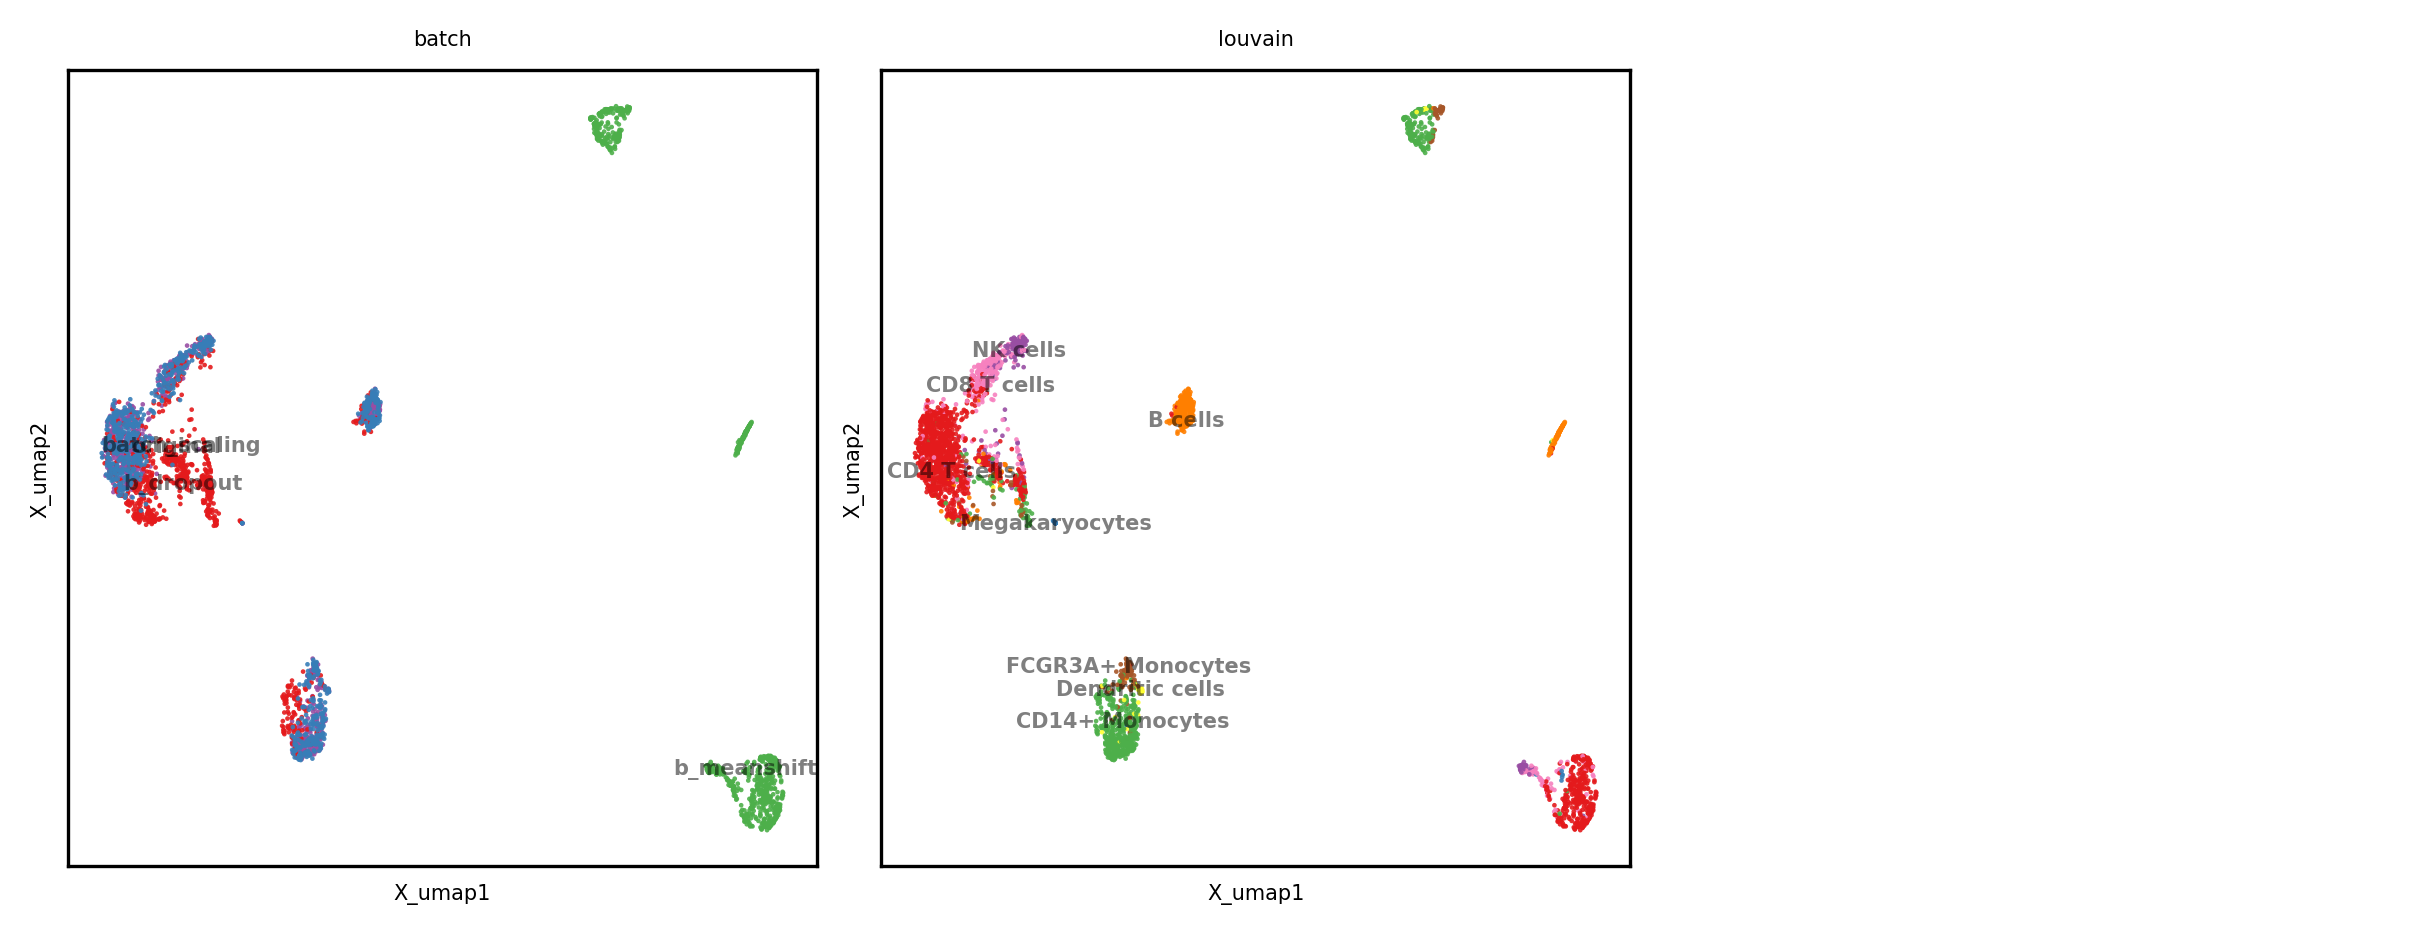

In [143]:
show_basis = 'X_umap'
show_cols = ['batch', 'louvain']
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

## scVI

In [91]:
import scvi

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
output_key = 'scVI'
adata.obsm[output_key] = vae.get_latent_representation()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|██████████| 400/400 [01:33<00:00,  4.22it/s, v_num=1, train_loss_step=2.81e+3, train_loss_epoch=2.48e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:33<00:00,  4.27it/s, v_num=1, train_loss_step=2.81e+3, train_loss_epoch=2.48e+3]


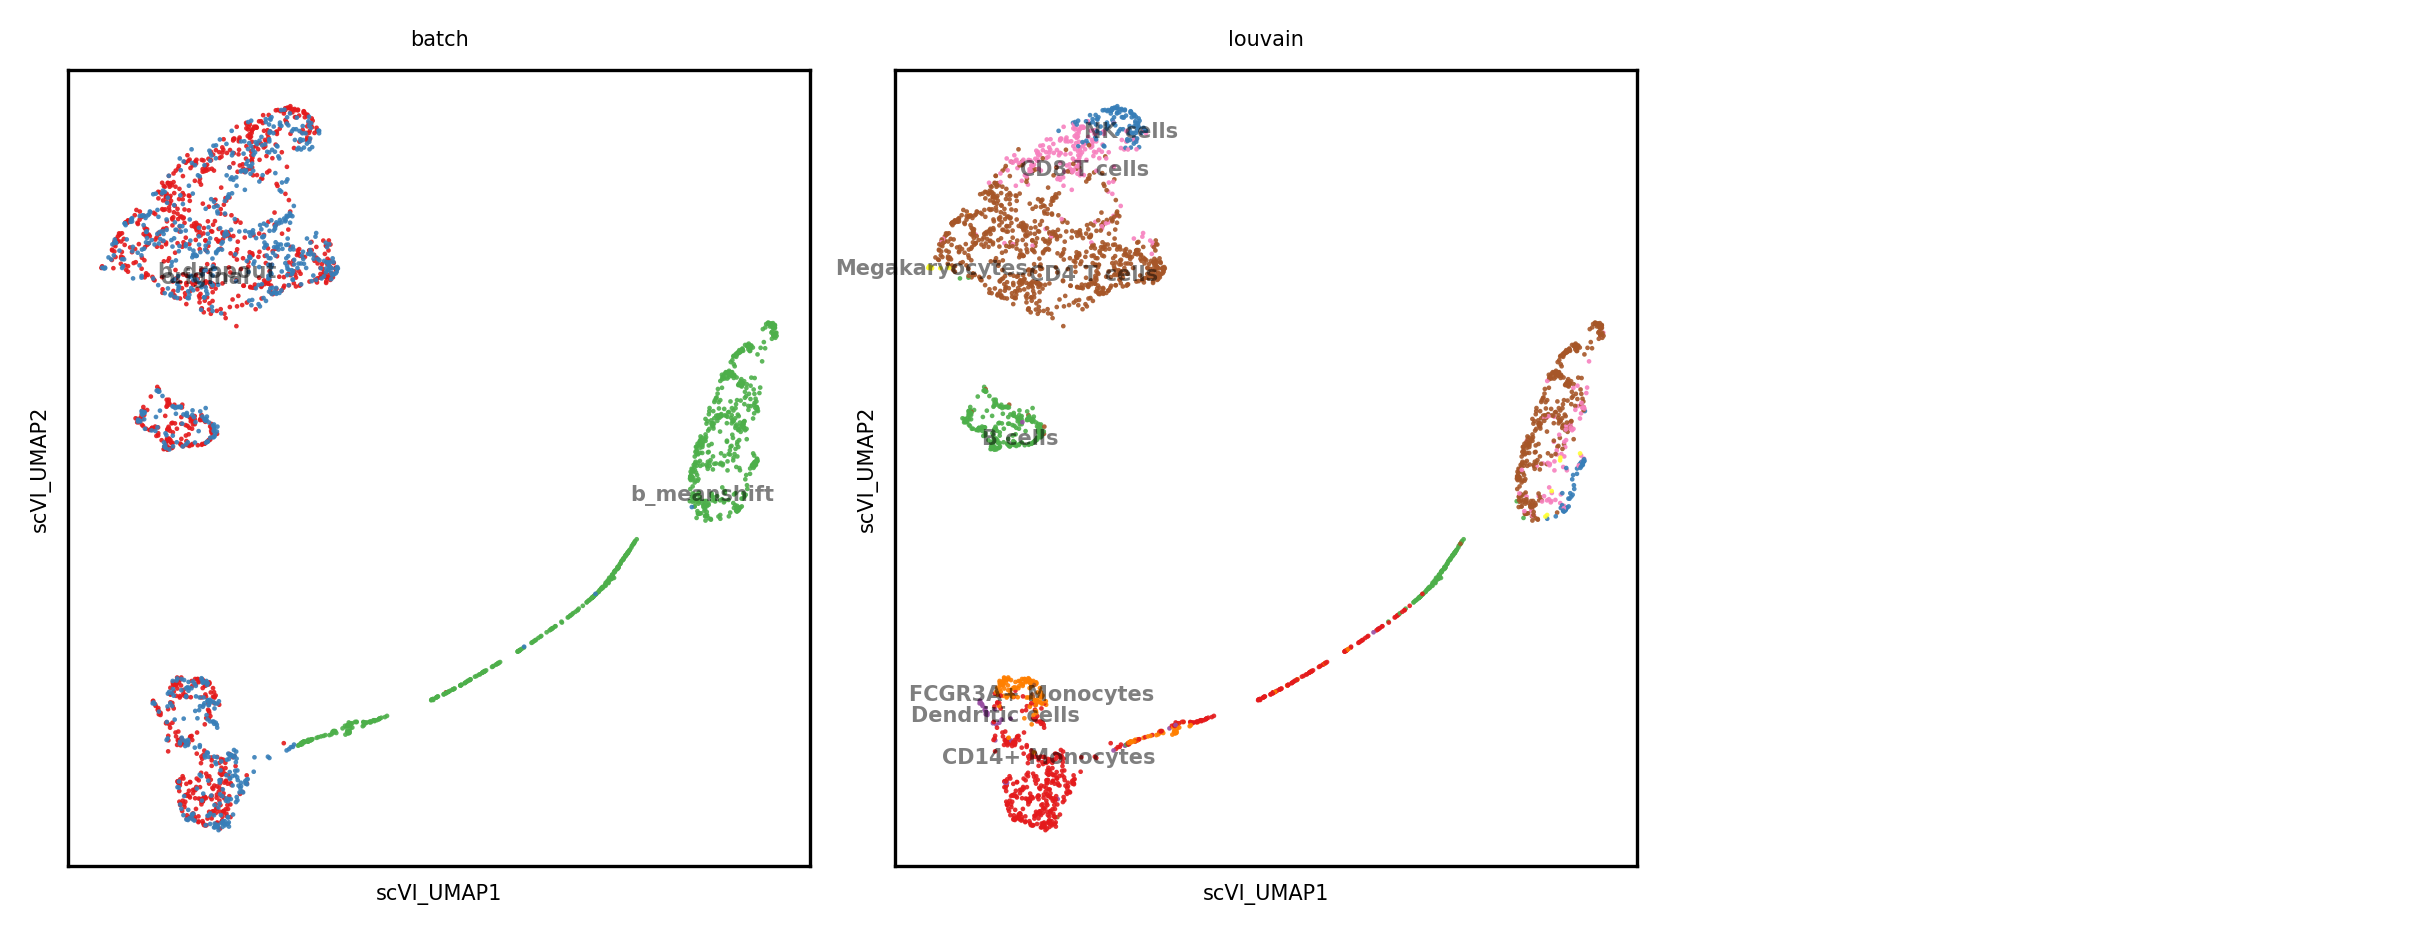

In [93]:
output_key = 'scVI'
ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

In [144]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      n_epochs=50,
                      domain_key='batch', # key indicating batch
                      augmentation_mask_prob = 0.5, # augmentation mask probability, recommend between 0.1 and 0.7
                      clr_temperature = 0.5, # temperature for NT-Xent loss
                      seed=seed, # random seed
                      p_intra_domain = 1.0, # probability of intra-domain sampling
                      verbose=False, # print training progress
                      inplace=True, # whether to modify original adata, set to False if you want to keep all expressions
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


Epoch 0 Training: 52it [00:00, 105.82it/s, loss=4.59]
Epoch 49 Training: 100%|██████████| 52/52 [00:00<00:00, 108.18it/s, loss=3.77]


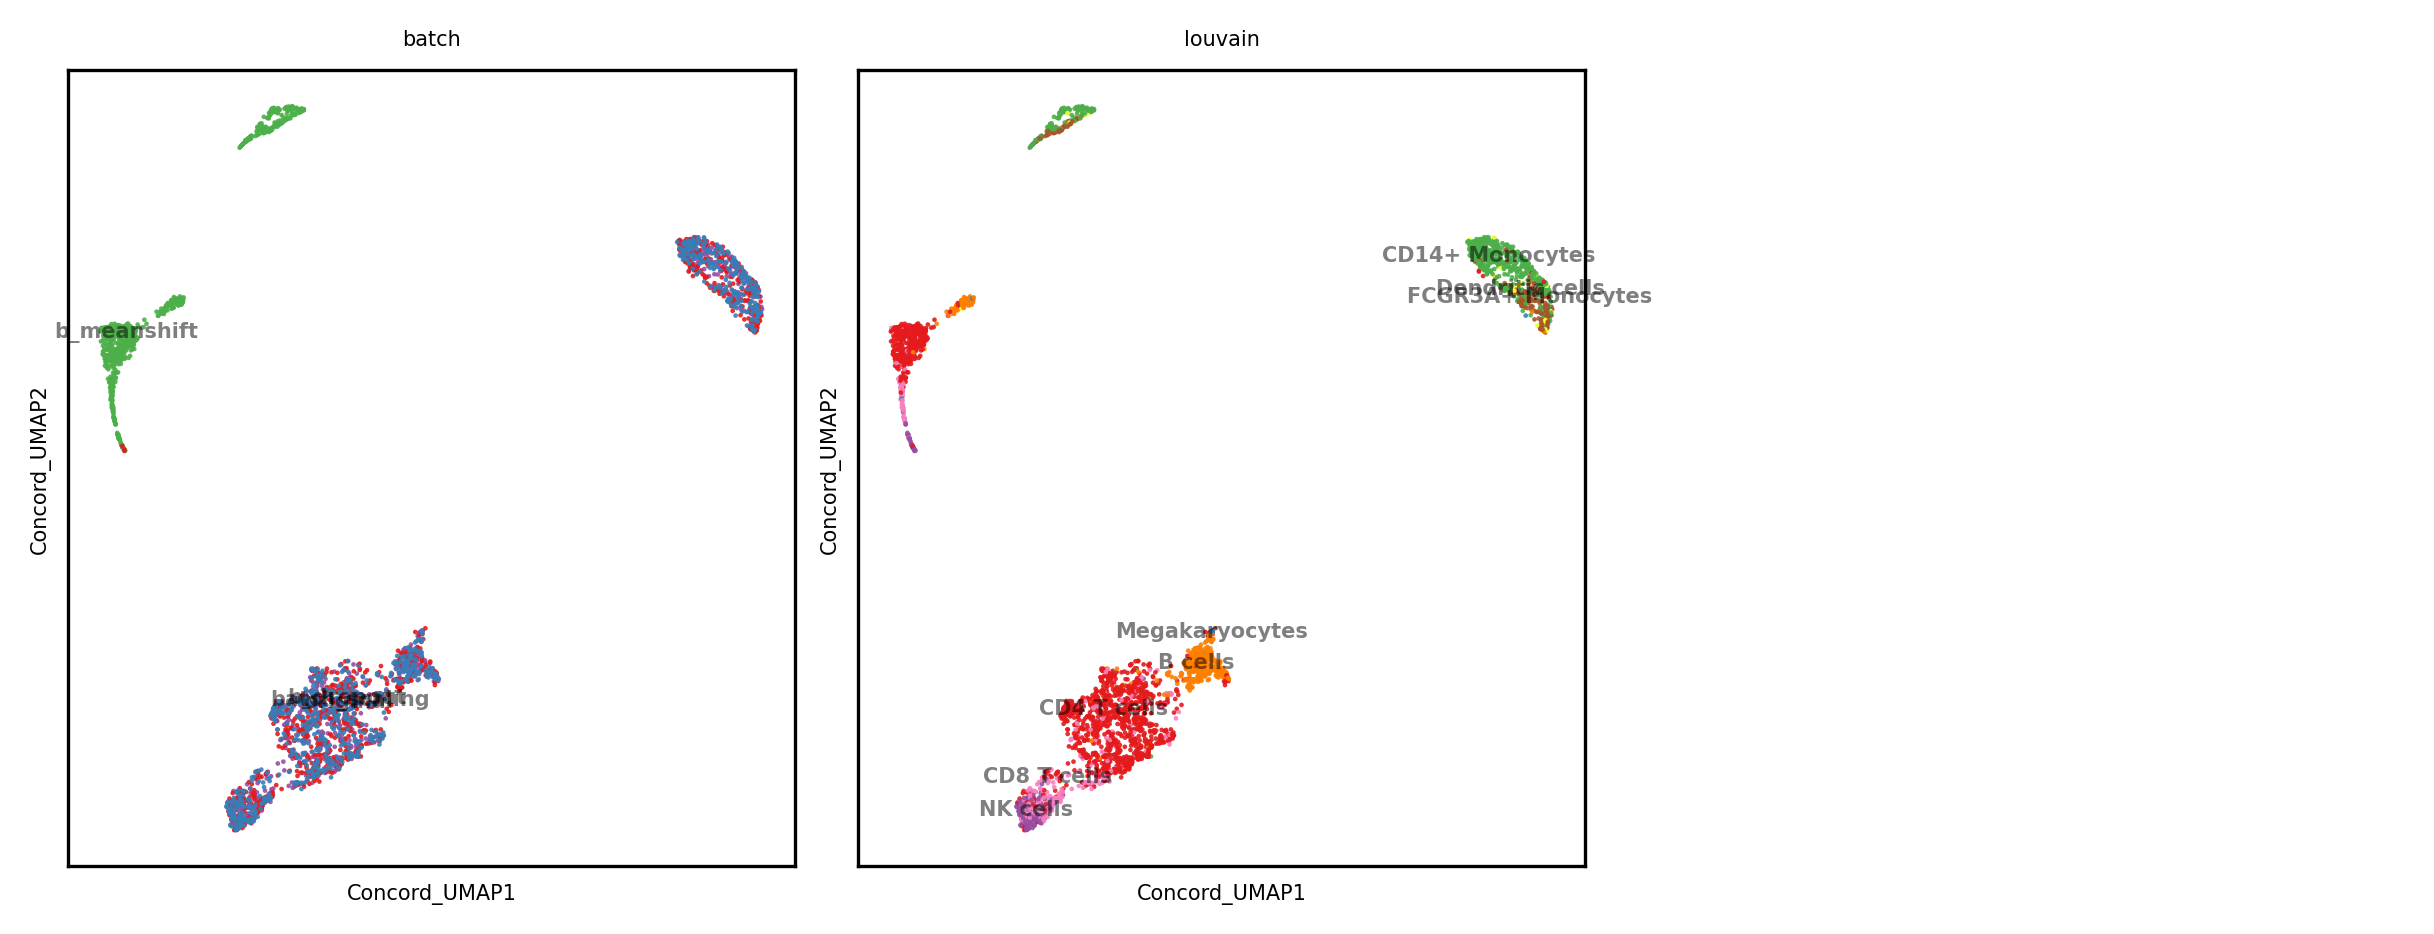

In [145]:
ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
output_key = 'Concord'
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)